# Classification of pests with CNN

In [1]:
import torch
import jcopdl
from torch import nn, optim
from jcopdl.callback import Callback, set_config

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [4]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])


In [5]:
train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, shuffle=True, batch_size=bs, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, shuffle=True, batch_size=bs)

In [6]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [7]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

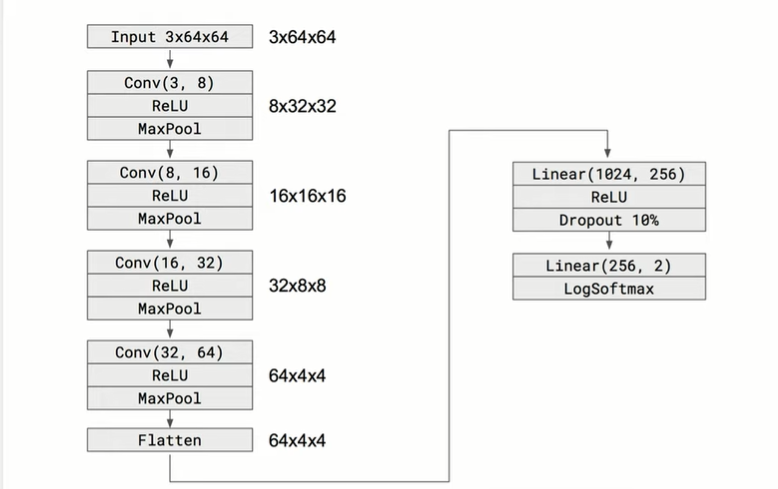

In [8]:
from IPython.display import Image
Image("data/arsitektur.png")

In [9]:
from jcopdl.layers import conv_block, linear_block

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x
         

In [11]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Training preparation -> MCOC

In [13]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

In [16]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval() 
    cost = correct = 0 
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) 
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward() 
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch    22
Train_cost  = 0.3896 | Test_cost  = 0.4008 | Train_score = 0.8330 | Test_score = 0.8125 |
==> EarlyStop patience =  6 | Best test_score: 0.8350
==> Execute Early Stopping at epoch: 22 | Best test_score: 0.8350
==> Best model is saved at model


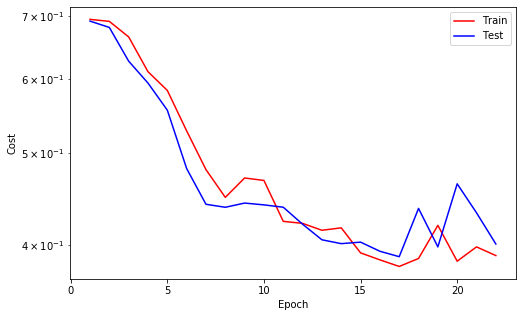

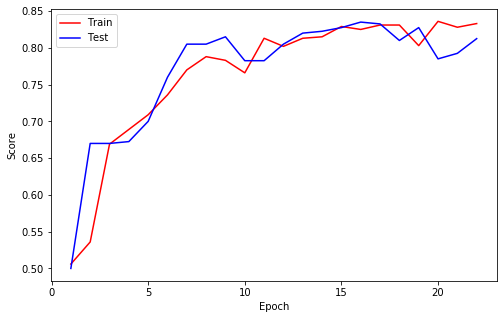

In [18]:
   
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
         test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
         
    # Logging and Reporting
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break
    

# predict

In [19]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)


In [20]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds
    

tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0])

In [21]:
import matplotlib.pyplot as plt

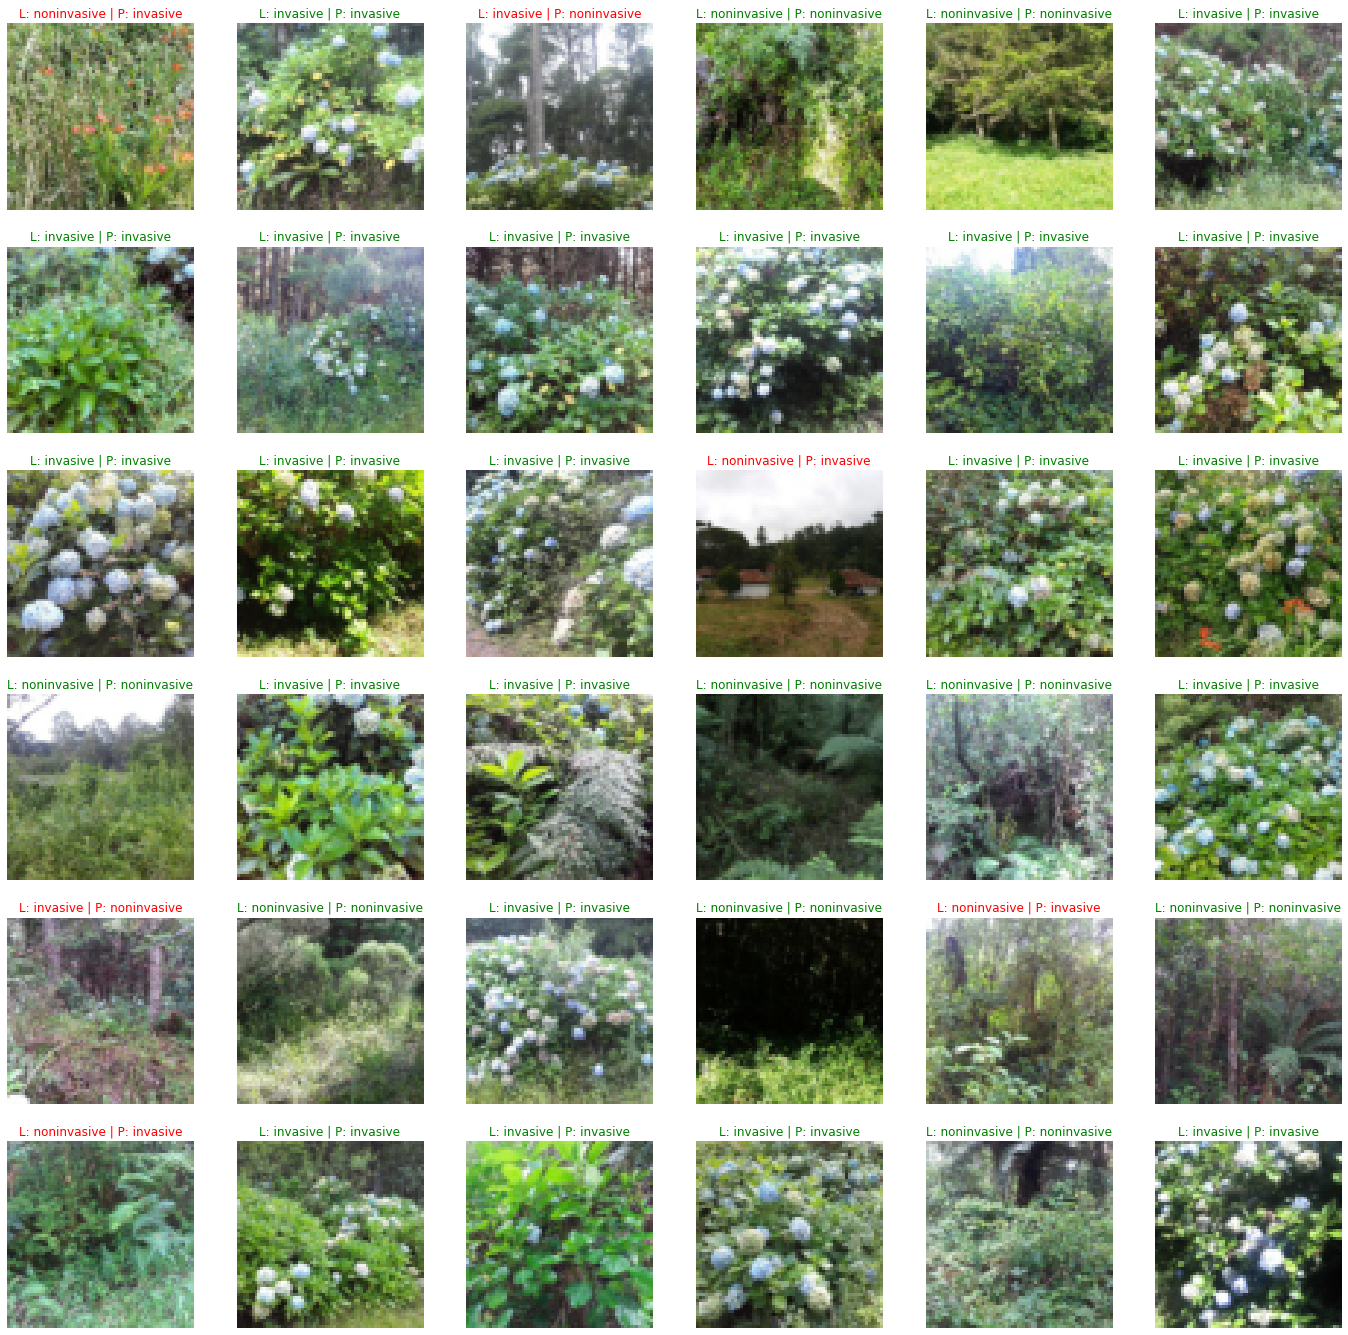

In [22]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font)
    ax.axis("off");